In [1]:
import anndata
import pandas as pd
from GenePanelDesign.api import GenePanelDesigner, GenePanelSummerizer

# load data

Users will need a cell by gene matrix (```AnnData```) from single cell expriments, 

In [2]:
adata = anndata.read_h5ad('count.h5ad')
adata

AnnData object with n_obs × n_vars = 297651 × 19296

And a design table with the aspects (col) of interest in the gene panel design.

In [3]:
design_df = pd.read_csv('meta.csv',index_col=0)
design_df.sample(10)

/data/wtian/local/miniconda3/envs/sapiens/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,RnaCellType,MethylCellType,L23IT-Region,MSN-D1-Region
index,,,,
10X228_1:GGAGGTAGTTCTTCAT,L6 CT/b,L6-CT,NaN,NaN
10X145_5:GCATGATGTTATGTCG,MSN,MSN-D1,NaN,NAC
10X269_4:AATTCCTGTAGGACTG,L2/3 IT,L2/3-IT,A46,NaN
10X375_1:TCAGCCTGTTATCTGG,MSN,MSN-D1,NaN,SI
10X176_7:AAACGCTCAAGCTACT,L2/3 IT,L2/3-IT,A46,NaN
10X362_1:GCCAGCAGTTCGGCTG,Thalamic excitatory,CB,NaN,NaN
10X265_3:ATCCATTGTTGGGAAC,L2/3 IT,L2/3-IT,LEC,NaN
10X360_6:GTACAGTTCGGATAAA,Cerebellar inhibitory,PKJ,NaN,NaN
10X349_2:GGGTAGAAGAGTATAC,MGE interneurons,Pvalb,NaN,NaN


# panel design

## initialize the gene panel designer

initialize the designer with a cell by gene matrix  and a design table (meta table). If it is a count matrix (```is_count_matrix```), the matrix wiil be normalized to ```log(1+CPM)``` first, and then selected top 10,000 highly varialbe genes.

Users could do their own normalization and feature selection, and provide the result adata as the input. ```log(1+CPM)``` normalization is prefered, though this algrithm may also work for other kinds (not tested yet).

In [4]:
designer = GenePanelDesigner(adata, design_df, 
                             downsample_per_group = 500,
                             downsample_max = 20000,
                             is_count_matrix=True,
                             n_jobs = 40,)

processing the data ...
	Input is count matrix. Normalizing and selecting highly variable genes
Done.
Initialize gene selectors ... Done.


## design panel for each aspect

The ```make_panels``` method makes a single panel for each aspect (col) in the design table

The algorithm will need some seed genes to start the panel construction.

These seed genes can be provided by users with the parameter of ```genes_to_include``` if there are any pre-selected genes of interests. 

Alternatively, the algorithm will automatically initialize with some genes as seeds with the parameter of ```init_panel_with```. Currently, there are two methods for such initialization: 1) one-vs-rest marker calling (```ovr```) and 2) genes with top mutual information (```mi```) against categorical information in the design table.

In [5]:
genes_to_include=['CUX2','LAMP5','RORB','VIP','SST','DRD1','DRD2',]
# genes_to_include = None

Users can specify the minimun and maximun numbers of genes for each aspect. 

Please note that these numbers will not be met exactly. 
For example, a single panel may end with 103 genes when 100 was specified as maximun gene number.

In [6]:

min_genes = {'MethylCellType':350,
             'RnaCellType':200,
             'L23IT-Region':100, 
             'MSN-D1-Region':100}
max_genes = min_genes

Users can specify the order of design of single panels. 
The late panel will be constructed with the genes from early panels as seed genes. 
The panels with the same order will be constructed independently.

For example, in the following case, the single panels for ```'MethylCellType'``` and ```RnaCellType``` will be firstly constructed independently. The panels for ```'L23IT-Region'``` and ```'MSN-D1-Region'``` will be constrcuted separately with the input of the results of ```'MethylCellType'``` and ```RnaCellType```.

In [7]:
order = {'MethylCellType':1, 
         'RnaCellType':1,
         'L23IT-Region':2, 
         'MSN-D1-Region':2}

The algorithm tries to maximize the pairwise distances between the categories of the aspect to certain extent.
This extent is specified by a soft parameter ```dist_ratio```. 

For example, when setting ```dist_ratio=0.2```, 
the algorithm will try to make the category pairwise distance with the selected genes 
to 20% of the distance with the full gene list.

In practice, set ```dist_ratio=0.1``` or ```=0.2``` will be sufficent, 
and usually ends up with more than 0.5 with the final gene panel 

In [8]:
panels = designer.make_panels(order=order, genes_to_include=genes_to_include, 
                              min_genes=min_genes, 
                              max_genes=max_genes,
                              dist_ratio=0.2,
                              fdr=0.05,
                              init_panel_with='ovr', 
                              rank_genes_with='welch-t')


Genes will be selected in the order of 

V
|
|
+------ user-specified: 7
|
|
+------ MethylCellType : 350
+------ RnaCellType : 200
|
|
+------ L23IT-Region : 100
+------ MSN-D1-Region : 100
|
|
V

Analyzing...


For the condition MethylCellType: 100%|█████████████████████████████████████| 1.0/1.0 [00:03<00:00,  3.34s/it]
For the condition RnaCellType: 100%|████████████████████████████████████████| 1.0/1.0 [00:02<00:00,  2.19s/it]
For the condition L23IT-Region: 100%|███████████████████████████████████████| 1.0/1.0 [00:01<00:00,  1.80s/it]
For the condition MSN-D1-Region: 100%|██████████████████████████████████████| 1.0/1.0 [00:01<00:00,  1.41s/it]


## combine panels for the final design

```finalize_panels``` combines signle gene panels to a final panel. 
This usually involves remove genes if the total gene number from each aspect is larger than demanded.

Users could specified the impoartance of each aspect with the parameter ```weights```.

In [9]:
weights = {'MethylCellType':1, 
           'RnaCellType':0.8,
           'L23IT-Region':0.3, 
           'MSN-D1-Region':0.3}

In [10]:
final_panel = designer.finalize_panels(panels, final_genes=500, weights=weights)

804 gene candidates -> 500 final genes


Remove less informative genes : 100%|███████████████████████████████████████| 304/304 [04:05<00:00,  1.24it/s]


# check design

the final panel

In [11]:
final_panel.sample(5)

,Name,Reason,PrevCount,welch-t,p-val,adj_p-val,diff,fc,significant,fg,bg,score
gene,,,,,,,,,,,,
BCL2,L23IT-Region,< min-genes,567,10.395849,8.180556e-24,2.017643e-21,1.687937,1.876701,True,A46,M1C,10.395849
MAJIN,MethylCellType,< dist-cutoff,96,5.351012,6.338652e-08,5.792894e-05,0.058856,8.549772,True,PC,VLMC,5.351012
COL1A1,MSN-D1-Region,< dist-cutoff,537,5.731054,8.421097e-09,6.058277e-06,0.734944,2.282628,True,SI,BNST,5.731054
KCNJ6,MSN-D1-Region,< dist-cutoff,517,15.988119,2.589564e-47,6.668128e-45,2.070768,4.726870,True,SI,NAC,15.988119
SFT2D2,L23IT-Region,< min-genes,533,27.237713,4.803071e-107,2.486013e-104,1.718794,13.126223,True,LEC,A46,27.237713


## overview of the panel

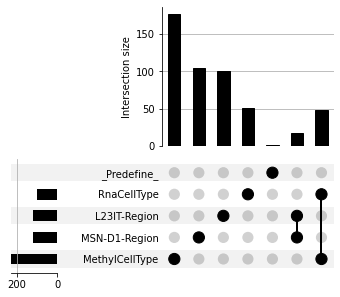

In [12]:
gxc = GenePanelSummerizer.summarize_gene_by_condition(final_panel)

## how each gene separate categories

In [13]:
gxc.sample(5)

Name,L23IT-Region,MSN-D1-Region,MethylCellType,RnaCellType,_Predefine_
gene,,,,,
WIF1,NaN,NaN,Sncg > Vip,NaN,NaN
TAC3,NaN,NaN,Vip > Sncg,NaN,NaN
STK17B,NaN,BNST > SI,NaN,NaN,NaN
ADCYAP1,NaN,NaN,SubCtx-Cplx > Chd7,Mammillary body > Cerebellar inhibitory,NaN
SCNN1A,NaN,NaN,PC > EC,NaN,NaN


pairwise distance for 


/data/wtian/local/miniconda3/envs/sapiens/lib/python3.8/site-packages/GenePanelDesign/api/summary.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


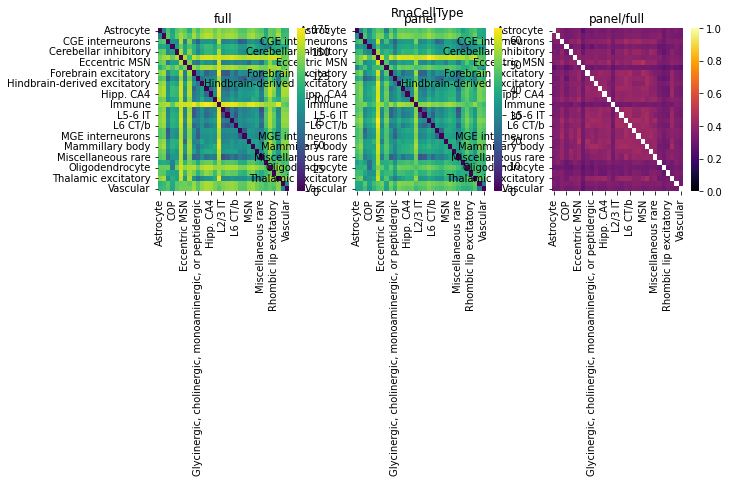

pairwise distance for 


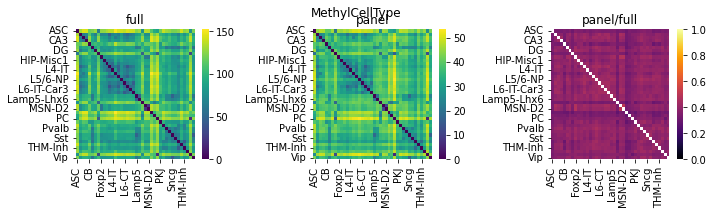

pairwise distance for 


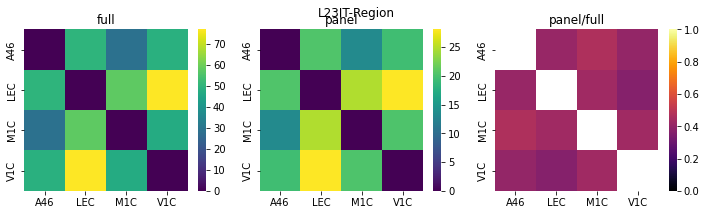

pairwise distance for 


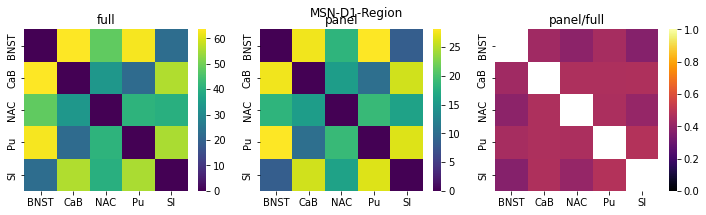

In [14]:
for aspect in designer.names:
    print('pairwise distance for ')
    GenePanelSummerizer.summarize_dist_matrix(designer.selectors[aspect], final_panel.index)    


## how the gene panel separate categories in clustering

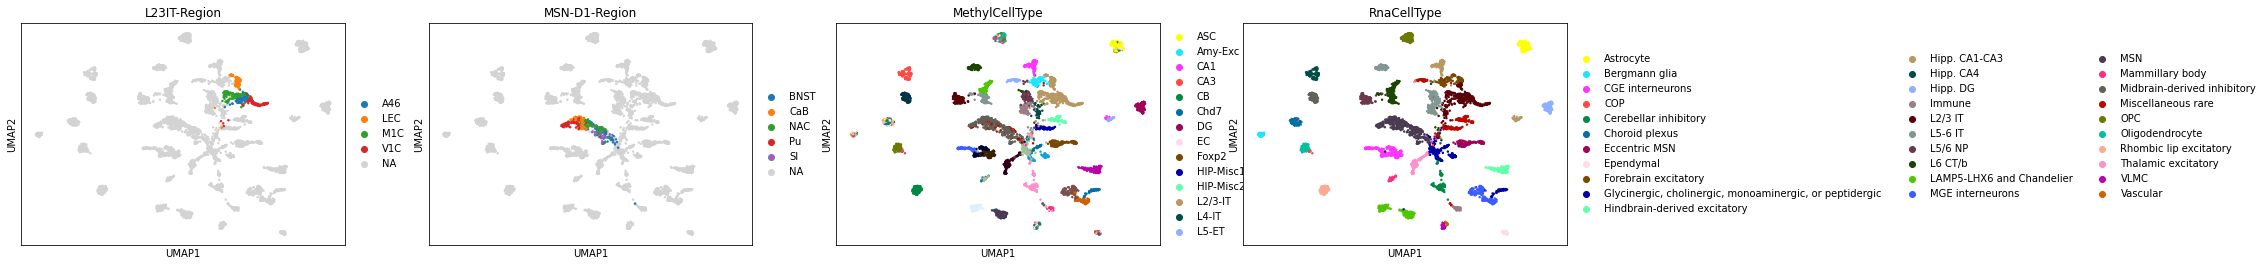

In [20]:
GenePanelSummerizer.check_clusters(designer.adata,  design_df, final_panel)
pass

## check expression profile

============================== frac ==============================
expression frac of selected genes for the aspect `RnaCellType`


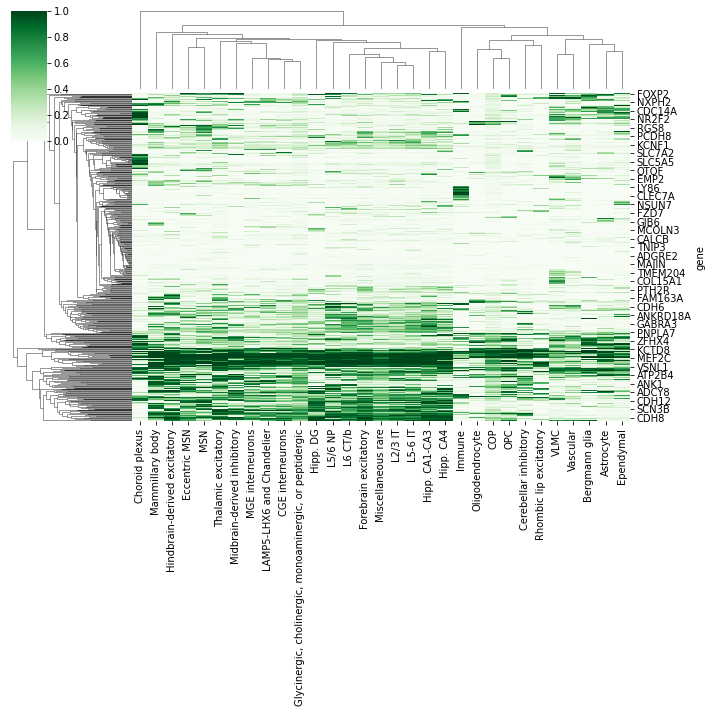

expression frac of non-selected genes for the aspect `RnaCellType`


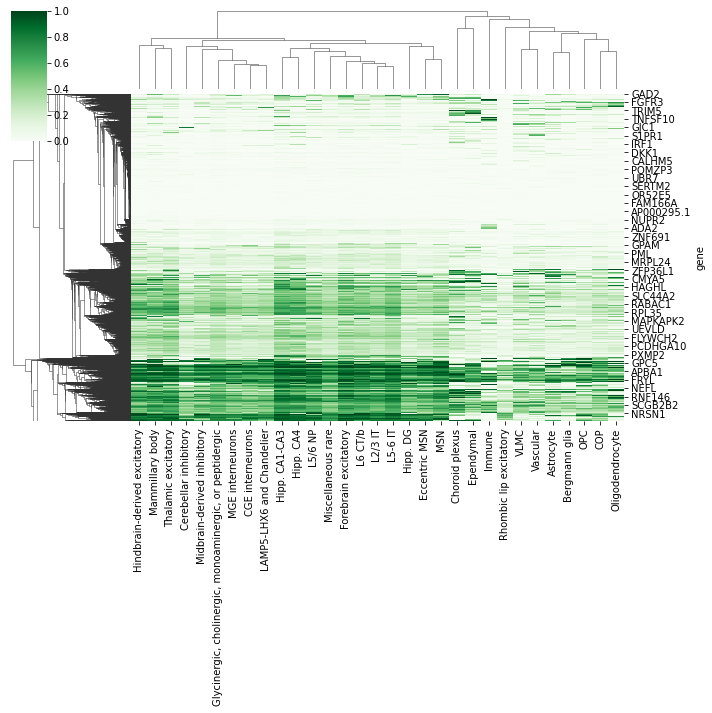

============================== z-score ==============================
expression z-score of selected genes for the aspect `RnaCellType`


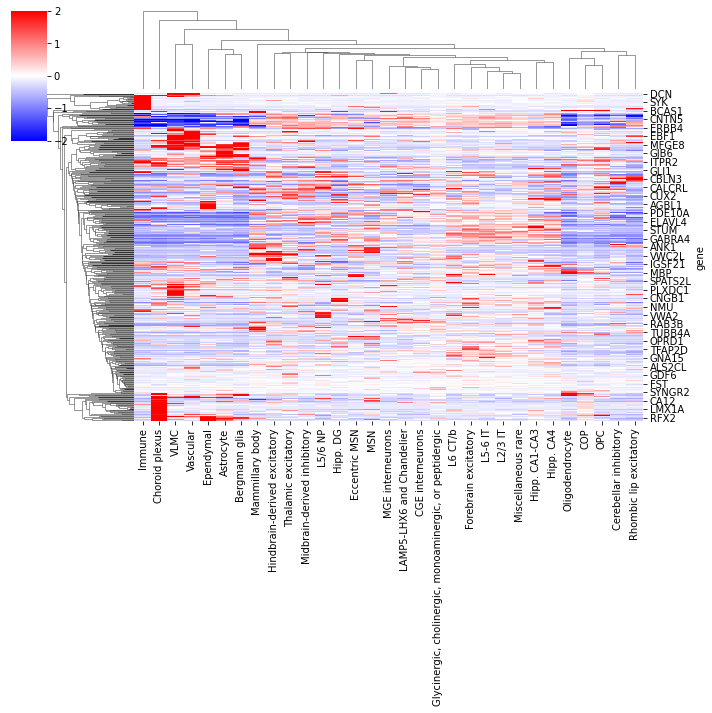

expression z-score of non-selected genes for the aspect `RnaCellType`


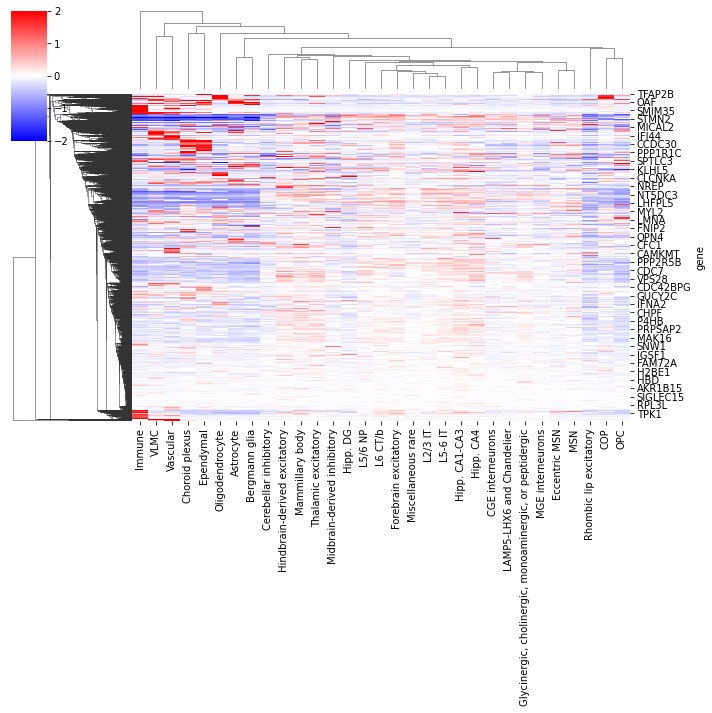

============================== expr ==============================
expression expr of selected genes for the aspect `RnaCellType`


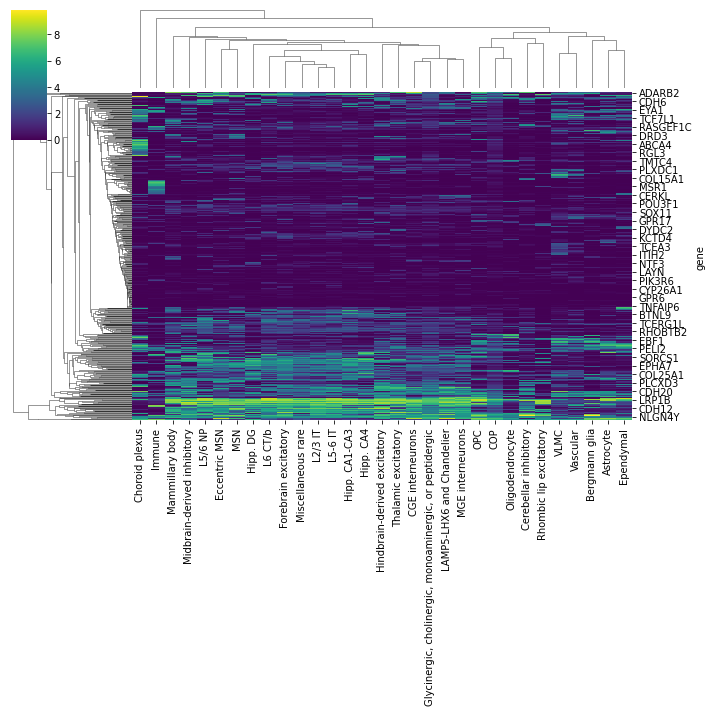

expression expr of non-selected genes for the aspect `RnaCellType`


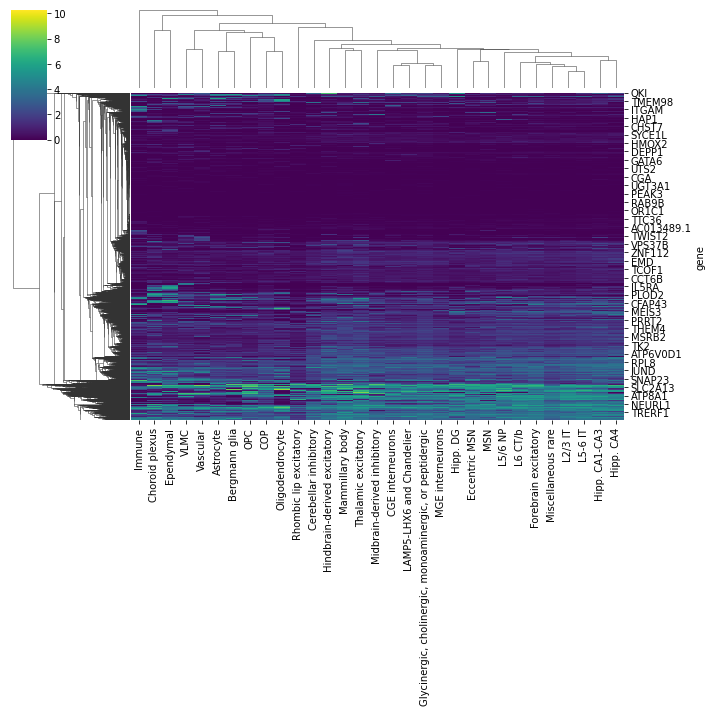

============================== frac ==============================
expression frac of selected genes for the aspect `MethylCellType`


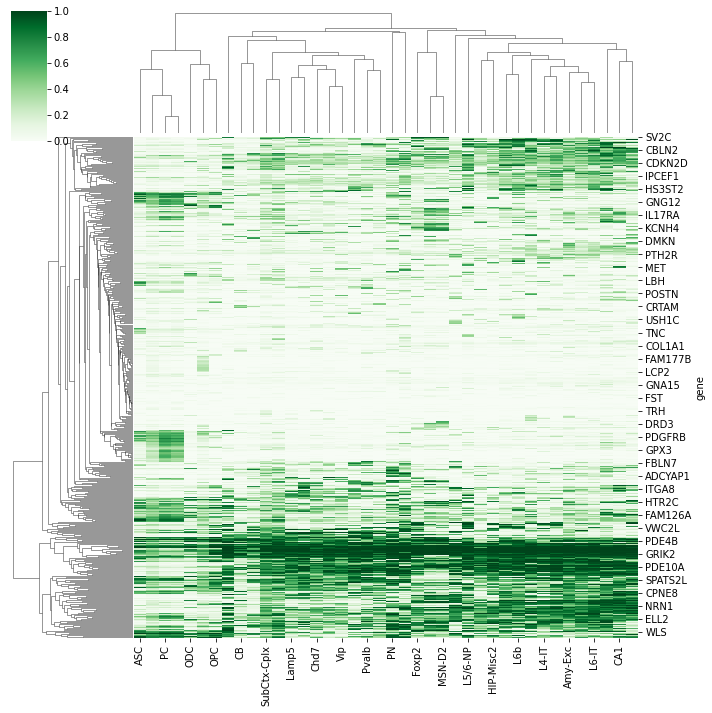

expression frac of non-selected genes for the aspect `MethylCellType`


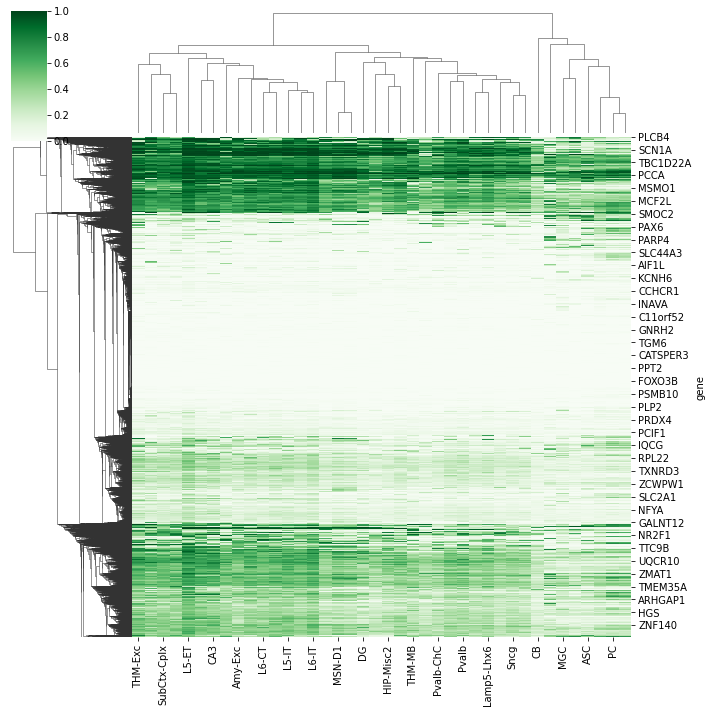

============================== z-score ==============================
expression z-score of selected genes for the aspect `MethylCellType`


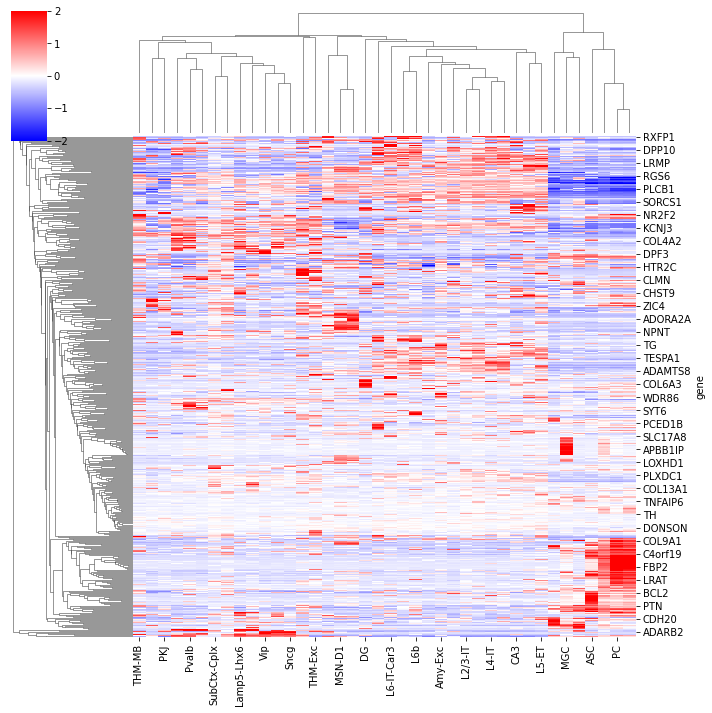

expression z-score of non-selected genes for the aspect `MethylCellType`


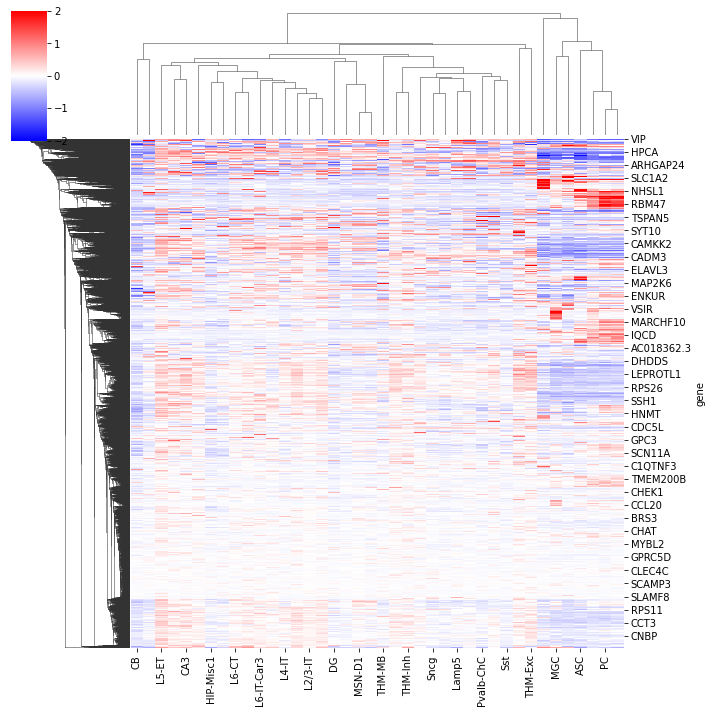

============================== expr ==============================
expression expr of selected genes for the aspect `MethylCellType`


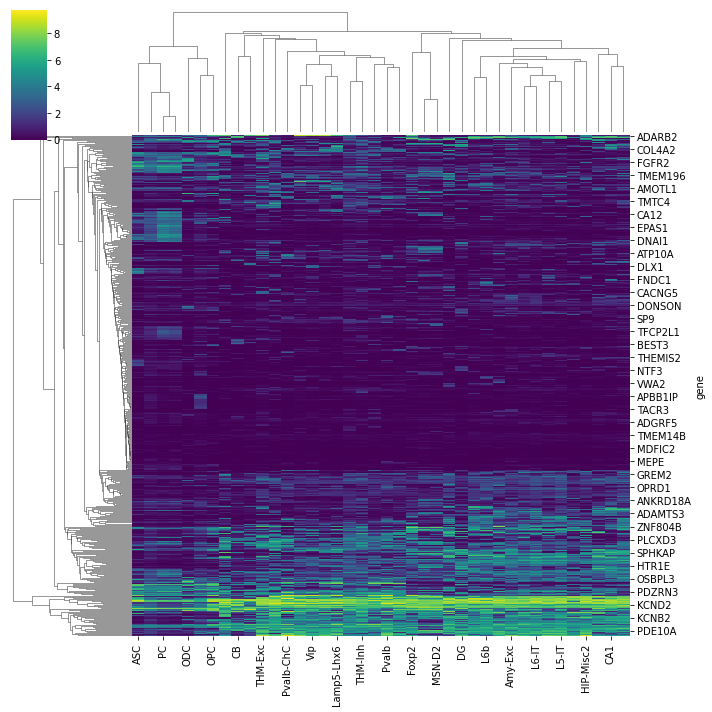

expression expr of non-selected genes for the aspect `MethylCellType`


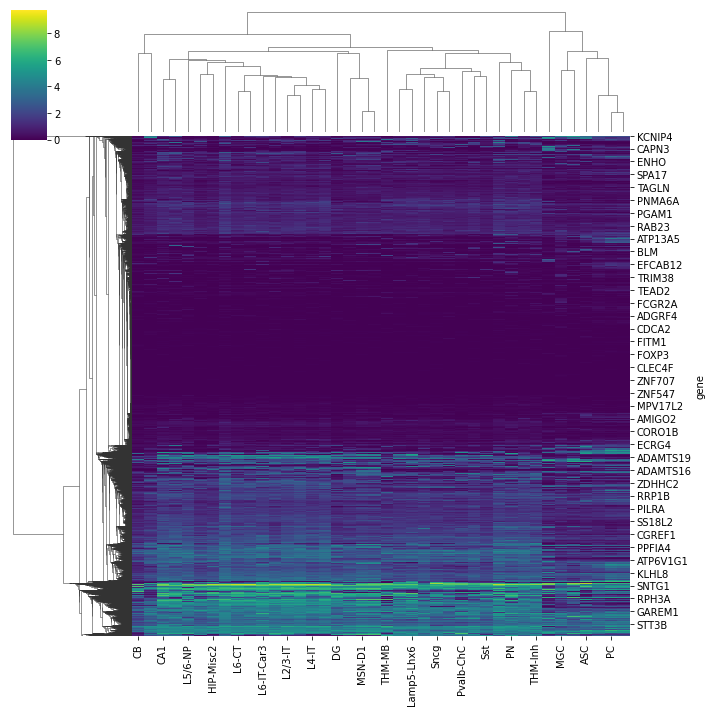

============================== frac ==============================
expression frac of selected genes for the aspect `L23IT-Region`


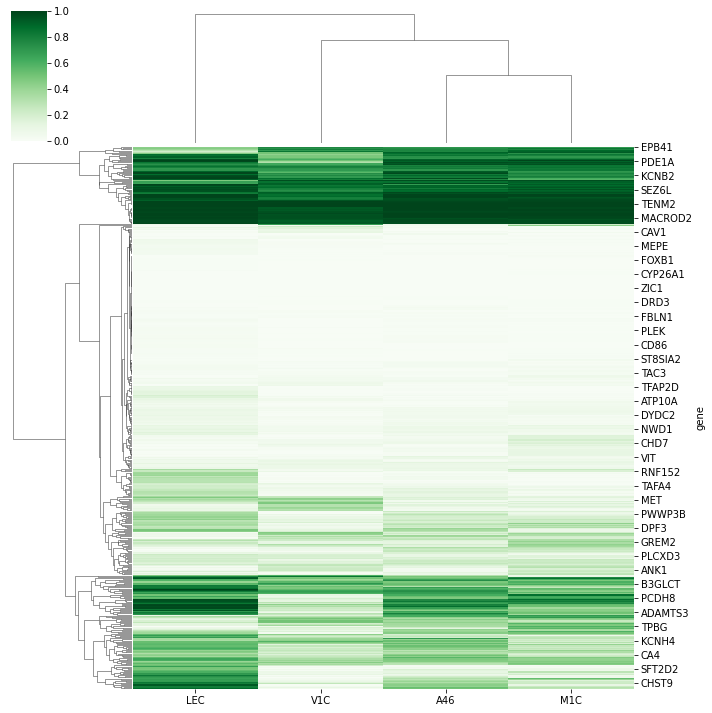

expression frac of non-selected genes for the aspect `L23IT-Region`


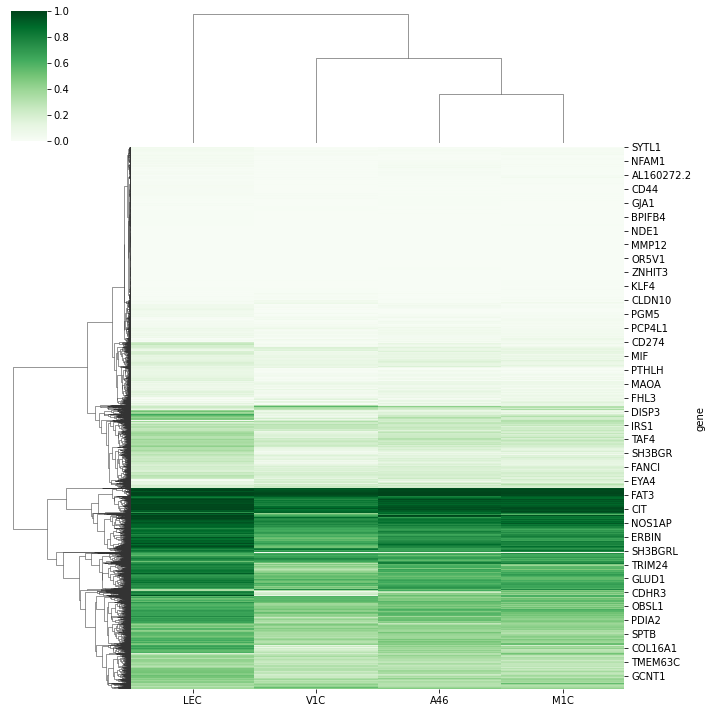

============================== z-score ==============================
expression z-score of selected genes for the aspect `L23IT-Region`


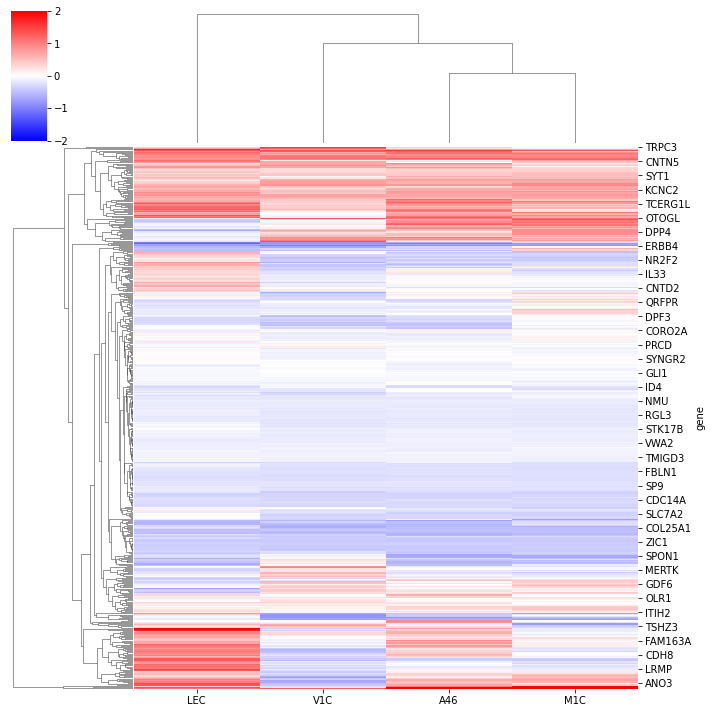

expression z-score of non-selected genes for the aspect `L23IT-Region`


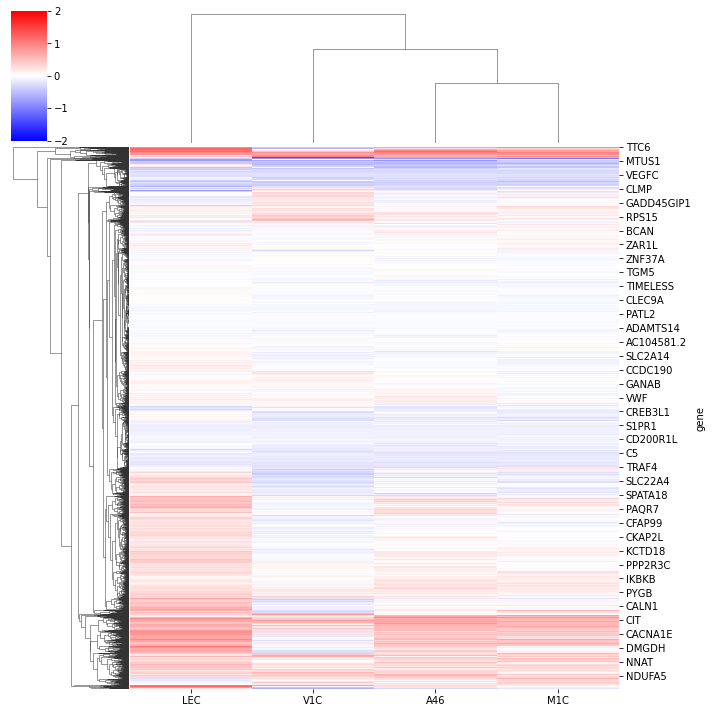

============================== expr ==============================
expression expr of selected genes for the aspect `L23IT-Region`


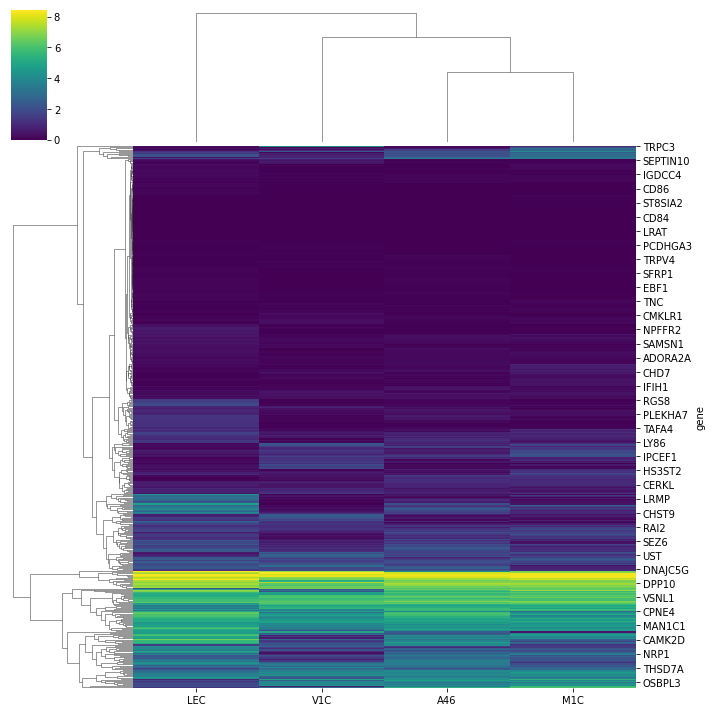

expression expr of non-selected genes for the aspect `L23IT-Region`


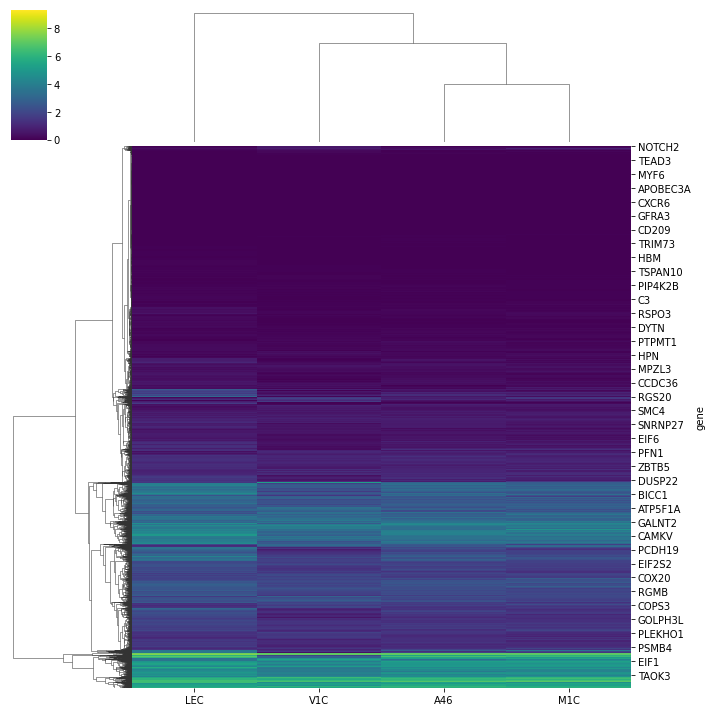

============================== frac ==============================
expression frac of selected genes for the aspect `MSN-D1-Region`


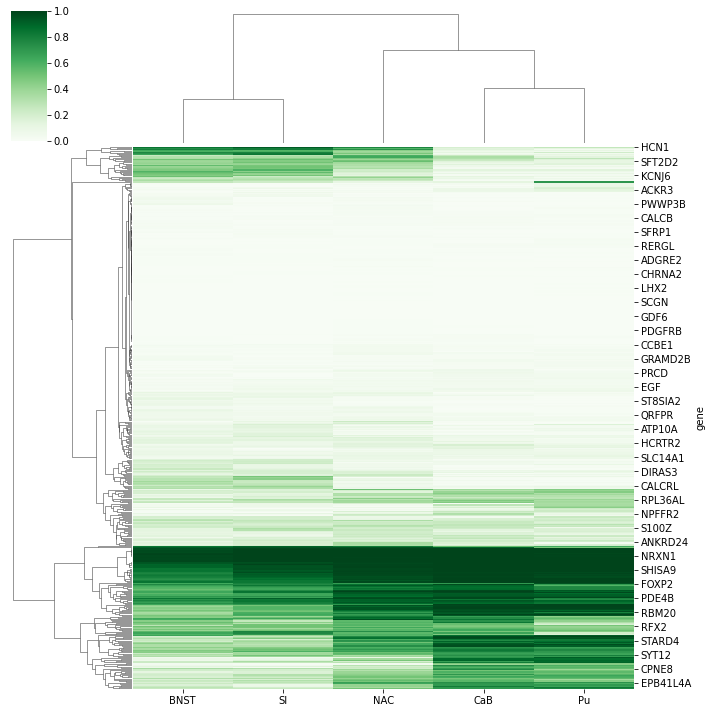

expression frac of non-selected genes for the aspect `MSN-D1-Region`


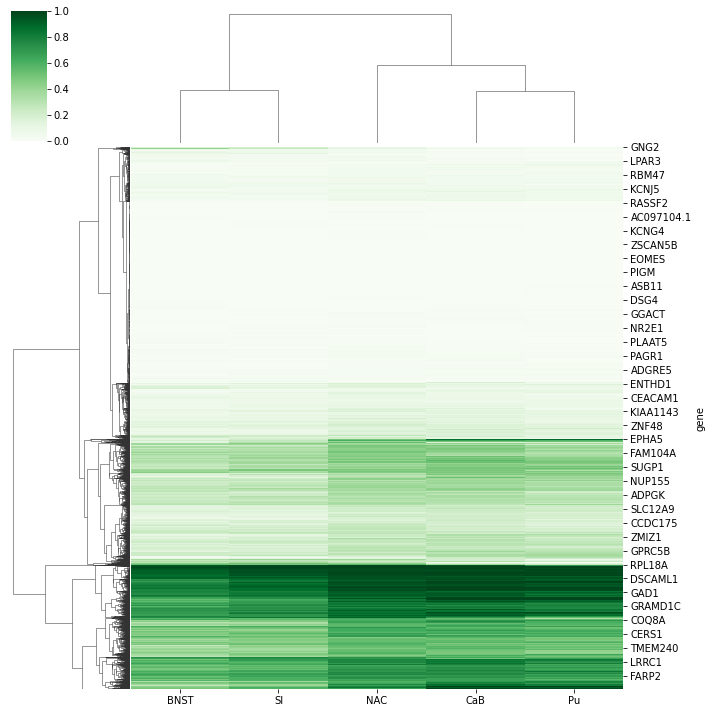

============================== z-score ==============================
expression z-score of selected genes for the aspect `MSN-D1-Region`


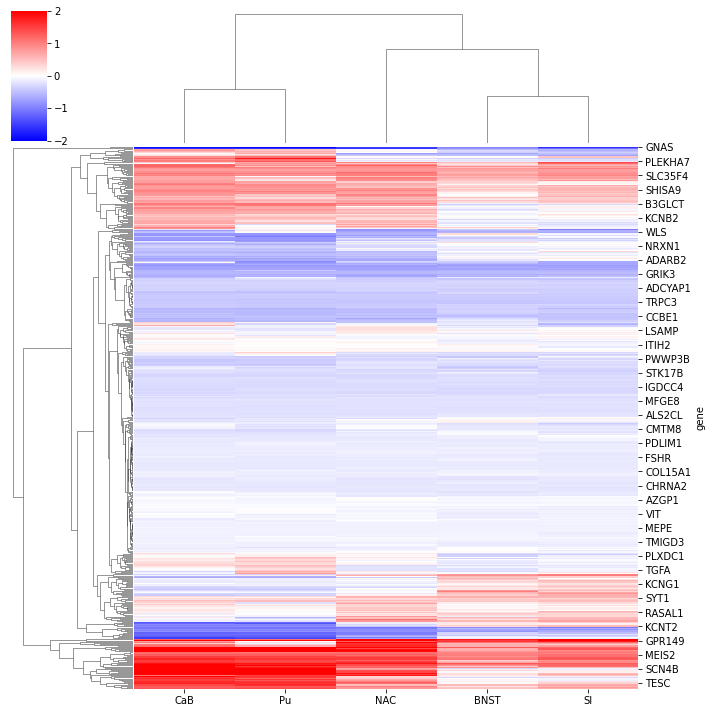

expression z-score of non-selected genes for the aspect `MSN-D1-Region`


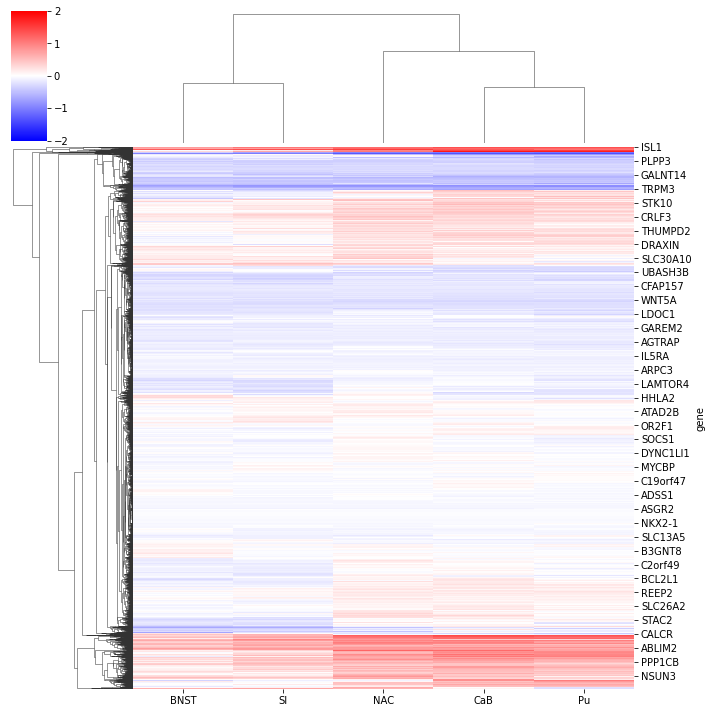

============================== expr ==============================
expression expr of selected genes for the aspect `MSN-D1-Region`


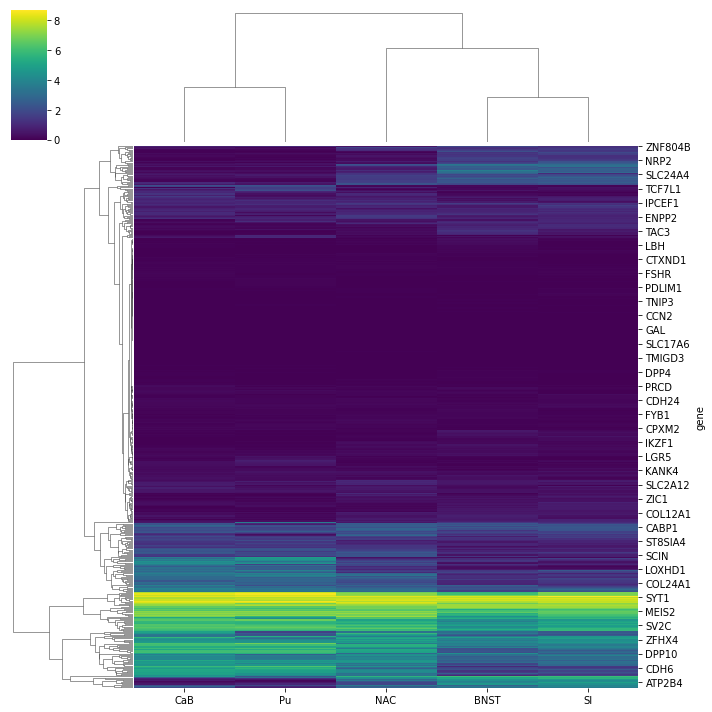

expression expr of non-selected genes for the aspect `MSN-D1-Region`


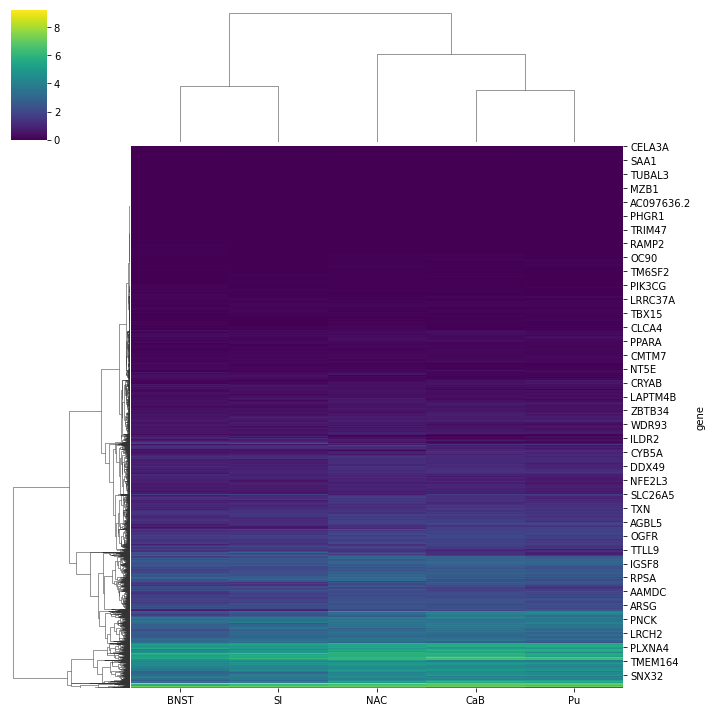

In [16]:
for aspect in designer.names:
    for kind in ['frac','z-score','expr']:
        print('='*30, kind, '='*30)
        print(f'expression {kind} of selected genes for the aspect `{aspect}`')
        sel = final_panel.index
        nosel = list(set(designer.adata.var_names)-set(sel))
        GenePanelSummerizer.summarize_expression(designer.adata, aspect, sel, kind=kind)
        print(f'expression {kind} of non-selected genes for the aspect `{aspect}`')
        GenePanelSummerizer.summarize_expression(designer.adata, aspect, nosel, kind=kind)